# Exercise 1

Authors:
    - Tuoxing Liu

## 1. Exploring the Data

In [112]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


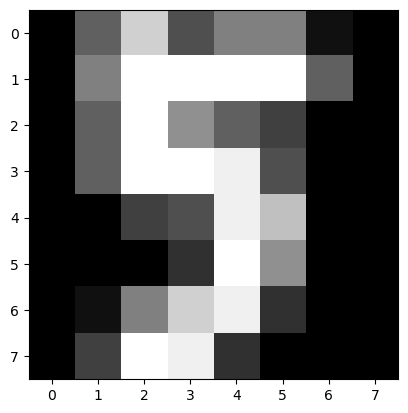

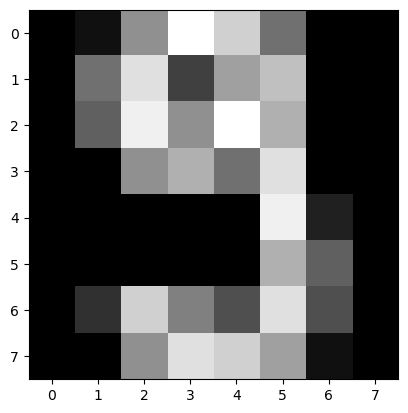

In [113]:
import numpy as numpy
import matplotlib.pyplot as plt

img = digits.images[33]

def print_img(img):
    assert 2 == len (img.shape)
    plt.figure()
    plt.gray()
    plt.imshow(img, interpolation = "nearest") # bicubic, nearest
    plt.show()

print_img(img)

def print_data(data):
    data_temp = data.reshape(8,8)
    print_img(data_temp)

print_data(digits.data[39])

In [114]:
from sklearn import model_selection
import numpy as np

filter_mask = np.logical_or(target == 3, target == 9)

X_all = data[filter_mask]
y_all = target[filter_mask]

y_all[y_all == 3] = -1
y_all[y_all == 9] = 1
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(
        X_all, y_all, test_size=0.4, random_state=0)

## 2. Hand-crafted classifier

### 2.1 Feature construcition

In [115]:
from scipy.signal import argrelextrema
def features2d(datas):
    features=[]
    for data in datas:
        mask = data > 12
        features.append([data[18]+data[26]+data[34]+data[42],data[11]+data[19]-data[35]-data[43]])
    
    return features

### 2.2 Scatterplot

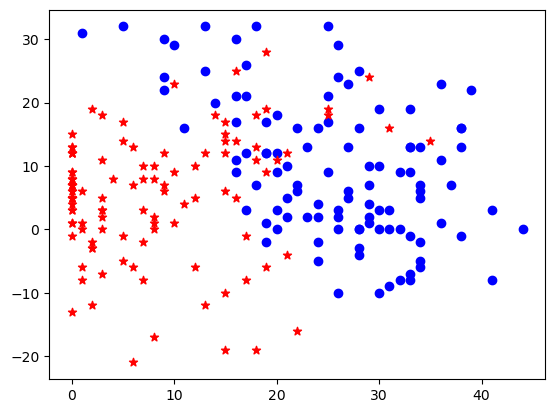

In [125]:
# X_train
# y_train

features = features2d(X_train)
def draw_feature(features,label):
    for feature,y in zip(features,label):
        if y == 3 or y == -1:
            marker = "*"
            color = "red"
        elif y == 9 or y == 1:
            marker ="o"
            color = "blue"
        plt.scatter(feature[0],feature[1],marker=marker,color=color)
    plt.show()

draw_feature(features,y_train)

### 2.3 Decision rule


In [127]:
def nearest_mean(training_features, training_labels, test_festures):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    f_negetive = t_features[t_labels == -1].mean()
    f_positive = t_features[t_labels == 1].mean()

    labels = []
    for f in test_festures:
        if abs(f-f_negetive).sum() > abs(f-f_positive).sum():
            labels.append(1)
        else:
            labels.append(-1)

    return labels


train_features = features2d(X_train)
test_features = features2d(X_test)

test_labels = nearest_mean(train_features, y_train, test_features)
train_labels = nearest_mean(train_features, y_train, train_features)

training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

training error: 0.3271889400921659
test error: 0.2876712328767123


### 2.4 Visualize the decision regions

In [137]:
f1 = np.linspace(0,50,200)
f2 = np.linspace(-10,40,200)

len(np.meshgrid(f1,f2))

2